# Workbook 03   Multi-Architecture Model Development

**Objective:** Systematic comparison of GNN architectures for subgraph-level AML
classification on Elliptic2, with Optuna-driven hyperparameter optimisation and
reproducible evaluation.

**Builds on:**
- Workbook 01: preprocessing pipeline, node features, stratified splits
- Workbook 02: dataset interface, LogReg + default GraphSAGE baselines

**Deliverables:**
- Tuned GraphSAGE, GCN, and GATv2 models with optimal hyperparameters
- Cross-architecture performance comparison (PR-AUC, ROC-AUC, F1)
- Cross-study comparison against Bellei et al. (2024) results
- Training curves, PR/ROC curves, confusion matrices
- Best model checkpoint for downstream explainability analysis

## 0. Configuration and reproducibility

In [1]:
import json
import random
import time
import warnings
from dataclasses import dataclass, field, asdict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from tqdm.auto import tqdm
import wandb
import os
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
)

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.nn import SAGEConv, GCNConv, GATv2Conv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.utils import to_undirected

warnings.filterwarnings("ignore", category=FutureWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Reproducibility
RNG_SEED = 7
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RNG_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Paths
PROJECT_ROOT = Path.cwd()
DATA_DIR     = PROJECT_ROOT / "DATA"
PROCESSED    = DATA_DIR / "processed"
ARRAYS_DIR   = PROCESSED / "arrays"
ARTIFACTS_DIR = PROCESSED / "artifacts"
PACK_DIR     = ARTIFACTS_DIR / "packed"
RESULTS_DIR  = PROJECT_ROOT / "results"
WB03_DIR     = RESULTS_DIR / "wb03"

WB03_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


Device: cuda
  GPU: NVIDIA GeForce RTX 5090
  Memory: 33.7 GB


In [ ]:
# ── Weights & Biases (remote experiment tracking) ──────────
WANDB_API_KEY = "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"  # Get from https://wandb.ai/authorize
WANDB_PROJECT = "elliptic2-gnn"
USE_WANDB = True  # Set False to disable wandb logging
os.environ["WANDB_NOTEBOOK_NAME"] = "wb03_model_development.ipynb"
if USE_WANDB:
    wandb.login(key=WANDB_API_KEY)
    print(f"wandb: enabled — project '{WANDB_PROJECT}'")

## 1. Load preprocessed artifacts

In [7]:
# Column schema (matches Wb01/Wb02)
NODE_ID_COL    = "clId"
NODES_COMP_COL = "ccId"
CC_LABEL_COL   = "ccLabel"

#   Core data                         
nodes = pd.read_parquet(PROCESSED / "parquet" / "nodes.parquet")
X     = np.load(ARRAYS_DIR / "node_features.npy")

subgraph_labels = {
    int(k): v
    for k, v in json.loads((ARTIFACTS_DIR / "subgraph_labels.json").read_text()).items()
}
splits = json.loads((ARTIFACTS_DIR / "splits.json").read_text())

#   Packing arrays (from Wb02)                ─
nodes_pack    = np.load(PACK_DIR / "nodes_by_ccid.npz")
edges_pack    = np.load(PACK_DIR / "edges_by_ccid.npz")

unique_cc       = nodes_pack["unique_cc"].astype(np.int64)
node_ptr        = nodes_pack["node_ptr"].astype(np.int64)
node_row_perm   = nodes_pack["node_row_perm"].astype(np.int64)

unique_cc_edges   = edges_pack["unique_cc_edges"].astype(np.int64)
edge_ptr          = edges_pack["edge_ptr"].astype(np.int64)
edge_src_row_perm = edges_pack["edge_src_row_perm"].astype(np.int64)
edge_dst_row_perm = edges_pack["edge_dst_row_perm"].astype(np.int64)

ccid_to_i  = {int(c): i for i, c in enumerate(unique_cc)}
ccid_to_ei = {int(c): i for i, c in enumerate(unique_cc_edges)}

def label_to_int(lbl: str) -> int:
    return 1 if str(lbl).lower() in {"suspicious", "illicit"} else 0

y_by_cc = {int(c): label_to_int(subgraph_labels[int(c)]) for c in unique_cc}

print(f"Nodes: {X.shape[0]:,}  Features: {X.shape[1]}")
print(f"Subgraphs: {len(unique_cc):,}  Suspicious: {sum(y_by_cc.values()):,}"
      f" ({100*sum(y_by_cc.values())/len(unique_cc):.2f}%)")
print(f"Splits   train: {len(splits['train']):,}  val: {len(splits['val']):,}"
      f"  test: {len(splits['test']):,}")

Nodes: 444,521  Features: 43
Subgraphs: 121,810  Suspicious: 2,763 (2.27%)
Splits   train: 85,267  val: 12,181  test: 24,362


## 2. Dataset and data loaders

In [8]:
class Elliptic2SubgraphDataset(torch.utils.data.Dataset):
    """Lazy PyG dataset: one Data object per subgraph (ccId).

    Each Data object contains:
        x:          [n_nodes, 43] float tensor   node features
        edge_index: [2, n_edges]  long tensor    undirected edges
        y:          [1]           long tensor     subgraph label
        ccId:       int                           component identifier
    """

    def __init__(self, ccids: np.ndarray, make_undirected: bool = True):
        self.ccids = ccids.astype(np.int64)
        self.make_undirected = make_undirected

    def __len__(self) -> int:
        return self.ccids.shape[0]

    def __getitem__(self, idx: int) -> Data:
        ccid = int(self.ccids[idx])
        i = ccid_to_i[ccid]
        rows = node_row_perm[node_ptr[i] : node_ptr[i + 1]]
        x = torch.from_numpy(X[rows]).float()

        local = {int(r): j for j, r in enumerate(rows.tolist())}

        if ccid in ccid_to_ei:
            ei = ccid_to_ei[ccid]
            s = edge_src_row_perm[edge_ptr[ei] : edge_ptr[ei + 1]]
            t = edge_dst_row_perm[edge_ptr[ei] : edge_ptr[ei + 1]]
            src = torch.tensor([local[int(r)] for r in s], dtype=torch.long)
            dst = torch.tensor([local[int(r)] for r in t], dtype=torch.long)
            edge_index = torch.stack([src, dst], dim=0)
            if self.make_undirected:
                edge_index = to_undirected(edge_index)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)

        y = torch.tensor([y_by_cc[ccid]], dtype=torch.long)
        return Data(x=x, edge_index=edge_index, y=y, ccId=ccid)


#   Instantiate splits                    ─
train_cc = np.array(splits["train"], dtype=np.int64)
val_cc   = np.array(splits["val"],   dtype=np.int64)
test_cc  = np.array(splits["test"],  dtype=np.int64)

train_ds = Elliptic2SubgraphDataset(train_cc)
val_ds   = Elliptic2SubgraphDataset(val_cc)
test_ds  = Elliptic2SubgraphDataset(test_cc)

#   Class weights (inverse frequency, computed on train only) ─
train_labels = torch.tensor([y_by_cc[int(c)] for c in train_cc], dtype=torch.long)
n_pos = int(train_labels.sum().item())
n_neg = int((train_labels == 0).sum().item())
CLASS_WEIGHTS = torch.tensor([1.0, n_neg / max(n_pos, 1)], dtype=torch.float32).to(DEVICE)

IN_DIM = X.shape[1]  # 43

print(f"Class weights: licit={CLASS_WEIGHTS[0]:.1f}, suspicious={CLASS_WEIGHTS[1]:.1f}")
print(f"Input feature dimension: {IN_DIM}")
print(f"Sample Data object: {train_ds[0]}")

Class weights: licit=1.0, suspicious=43.1
Input feature dimension: 43
Sample Data object: Data(x=[2, 43], edge_index=[2, 2], y=[1], ccId=118081)


## 3. Model architectures

Three GNN backbones, unified by a common interface:

| Architecture | Aggregation | Key property |
|:--|:--|:--|
| **GraphSAGE** | Learned mean/max with self/neighbour separation | Inductive, scalable |
| **GCN** | Degree-normalised symmetric sum | Spectral grounding, XAI baseline |
| **GATv2** | Dynamic learned attention weights | Intrinsic interpretability |

All models follow the same pattern:
`GNN layers → global pooling → MLP classification head`

In [9]:
POOL_FN = {"mean": global_mean_pool, "max": global_max_pool}


class SubgraphClassifier(nn.Module):
    """Unified GNN subgraph classifier.

    Architecture:
        [GNN backbone]  node-level message passing (n layers)
        [Global pool]   aggregate node embeddings per subgraph
        [MLP head]      two-layer classifier → 2-class logits

    Parameters
    ----------
    arch : str
        One of 'sage', 'gcn', 'gatv2'.
    in_dim : int
        Input feature dimension (43 for Elliptic2).
    hidden_dim : int
        Hidden dimension for GNN layers and MLP.
    num_layers : int
        Number of GNN message-passing layers.
    dropout : float
        Dropout probability applied after each GNN layer.
    pool : str
        Global pooling strategy: 'mean' or 'max'.
    heads : int
        Number of attention heads (GATv2 only; ignored for others).
    """

    def __init__(
        self,
        arch: str,
        in_dim: int,
        hidden_dim: int = 64,
        num_layers: int = 2,
        dropout: float = 0.0,
        pool: str = "mean",
        heads: int = 2,
    ):
        super().__init__()
        self.arch = arch
        self.dropout = dropout
        self.pool_fn = POOL_FN[pool]
        self.num_layers = num_layers

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        for i in range(num_layers):
            c_in = in_dim if i == 0 else hidden_dim

            if arch == "sage":
                self.convs.append(SAGEConv(c_in, hidden_dim))
            elif arch == "gcn":
                self.convs.append(GCNConv(c_in, hidden_dim))
            elif arch == "gatv2":
                if i < num_layers - 1:
                    # Intermediate: multi-head, concat → output = (hidden//heads)*heads
                    per_head = max(hidden_dim // heads, 1)
                    self.convs.append(GATv2Conv(c_in, per_head, heads=heads, concat=True))
                    # Override c_in for next layer
                    in_dim = per_head * heads
                    hidden_dim_actual = per_head * heads
                else:
                    # Final: single head → output = hidden_dim
                    self.convs.append(GATv2Conv(c_in, hidden_dim, heads=1, concat=False))
            else:
                raise ValueError(f"Unknown architecture: {arch}")

            # BatchNorm over actual output dim
            if arch == "gatv2" and i < num_layers - 1:
                self.bns.append(nn.BatchNorm1d(per_head * heads))
            else:
                self.bns.append(nn.BatchNorm1d(hidden_dim))

        #   MLP classification head  
        self.lin1 = nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 2)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            if self.dropout > 0:
                x = F.dropout(x, p=self.dropout, training=self.training)

        g = self.pool_fn(x, batch)
        g = F.relu(self.lin1(g))
        if self.dropout > 0:
            g = F.dropout(g, p=self.dropout, training=self.training)
        return self.lin2(g)


#   Smoke test                        ─
for arch in ["sage", "gcn", "gatv2"]:
    m = SubgraphClassifier(arch=arch, in_dim=IN_DIM, hidden_dim=64, heads=2)
    n_params = sum(p.numel() for p in m.parameters())
    print(f"{arch:6s} | params: {n_params:,}")

sage   | params: 18,370
gcn    | params: 11,522
gatv2  | params: 18,754


## 4. Training infrastructure

In [10]:
def evaluate(model: nn.Module, loader: PyGDataLoader) -> tuple[np.ndarray, np.ndarray]:
    """Run inference; return (y_true, y_score) arrays."""
    model.eval()
    ys, scores = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            logits = model(batch)
            prob = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            y = batch.y.cpu().numpy().reshape(-1)
            ys.append(y)
            scores.append(prob)
    return np.concatenate(ys), np.concatenate(scores)


def optimal_threshold(y_true: np.ndarray, y_score: np.ndarray) -> float:
    """Find the threshold that maximises F1 on a given split."""
    prec, rec, thresholds = precision_recall_curve(y_true, y_score)
    f1 = (2 * prec * rec) / (prec + rec + 1e-12)
    best_idx = int(np.nanargmax(f1))
    return float(thresholds[max(best_idx - 1, 0)]) if len(thresholds) else 0.5


def compute_test_metrics(y_true: np.ndarray, y_score: np.ndarray, threshold: float) -> dict:
    """Compute all test-set metrics at a given decision threshold."""
    y_pred = (y_score >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return {
        "test_pr_auc":     float(average_precision_score(y_true, y_score)),
        "test_roc_auc":    float(roc_auc_score(y_true, y_score)),
        "test_f1":         float(f1_score(y_true, y_pred)),
        "test_precision":  float(tp / max(tp + fp, 1)),
        "test_recall":     float(tp / max(tp + fn, 1)),
        "test_threshold":  float(threshold),
        "test_confusion":  cm.tolist(),
    }

In [ ]:
def train_and_evaluate(
    arch: str,
    hidden_dim: int,
    num_layers: int,
    dropout: float,
    lr: float,
    pool: str,
    heads: int = 2,
    batch_size: int = 256,
    max_epochs: int = 80,
    patience: int = 15,
    trial: optuna.Trial | None = None,
    verbose: bool = False,
    trial_num: int | None = None,
    show_epoch_progress: bool = False,
    epoch_progress_every: int = 1,
) -> dict:
    """Train a single model configuration end-to-end.

    If an Optuna trial is provided, reports intermediate values for pruning.
    Logs live epoch metrics to Weights & Biases when USE_WANDB is True.

    Returns a dict with all metrics, training history, and hyperparameters.
    """
    t0 = time.time()

    train_loader = PyGDataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = PyGDataLoader(val_ds, batch_size=512, shuffle=False)
    test_loader = PyGDataLoader(test_ds, batch_size=512, shuffle=False)

    model = SubgraphClassifier(
        arch=arch, in_dim=IN_DIM, hidden_dim=hidden_dim,
        num_layers=num_layers, dropout=dropout, pool=pool, heads=heads,
    ).to(DEVICE)

    n_params = sum(p.numel() for p in model.parameters())

    criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    best_val_pr = -1.0
    best_state = None
    best_epoch = 0
    bad_epochs = 0
    train_losses, val_pr_aucs, val_roc_aucs = [], [], []

    epoch_progress_every = max(1, int(epoch_progress_every))
    epoch_iter = range(1, max_epochs + 1)
    epoch_pbar = None

    if show_epoch_progress:
        trial_label = f"{arch.upper()} trial {trial_num}" if trial_num is not None else f"{arch.upper()} trial"
        epoch_pbar = tqdm(
            epoch_iter,
            total=max_epochs,
            desc=trial_label,
            leave=False,
            dynamic_ncols=True,
            position=1,
        )
        epoch_iter = epoch_pbar

    try:
        for epoch in epoch_iter:
            model.train()
            epoch_loss = 0.0
            for batch in train_loader:
                batch = batch.to(DEVICE)
                optimizer.zero_grad()
                logits = model(batch)
                loss = criterion(logits, batch.y.view(-1))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * batch.num_graphs

            avg_loss = epoch_loss / len(train_ds)
            train_losses.append(avg_loss)

            yv, sv = evaluate(model, val_loader)
            vp = float(average_precision_score(yv, sv))
            vr = float(roc_auc_score(yv, sv))
            val_pr_aucs.append(vp)
            val_roc_aucs.append(vr)

            # ── wandb: log epoch-level metrics ──
            if USE_WANDB and wandb.run is not None:
                wandb.log({
                    "train/loss": avg_loss,
                    "val/pr_auc": vp,
                    "val/roc_auc": vr,
                }, step=epoch)

            if epoch_pbar is not None and (
                epoch % epoch_progress_every == 0 or epoch == 1 or epoch == max_epochs
            ):
                epoch_pbar.set_postfix_str(
                    f"epoch {epoch}/{max_epochs} val_pr={vp:.4f}",
                    refresh=False,
                )

            if verbose and epoch % 10 == 0:
                print(f"    epoch {epoch:3d}  loss={avg_loss:.4f}"
                      f"  val_pr={vp:.4f}  val_roc={vr:.4f}")

            if trial is not None:
                trial.report(vp, epoch)
                if trial.should_prune():
                    if epoch_pbar is not None:
                        epoch_pbar.set_postfix_str(
                            f"epoch {epoch}/{max_epochs} pruned",
                            refresh=True,
                        )
                    raise optuna.TrialPruned()

            if vp > best_val_pr + 1e-4:
                best_val_pr = vp
                best_state = {k: v.detach().cpu().clone()
                              for k, v in model.state_dict().items()}
                best_epoch = epoch
                bad_epochs = 0
            else:
                bad_epochs += 1
                if bad_epochs >= patience:
                    if epoch_pbar is not None:
                        epoch_pbar.set_postfix_str(
                            f"epoch {epoch}/{max_epochs} early-stop",
                            refresh=True,
                        )
                    if verbose:
                        print(f"    early stop at epoch {epoch} (best={best_epoch})")
                    break
    finally:
        if epoch_pbar is not None:
            epoch_pbar.close()

    if best_state is not None:
        model.load_state_dict(best_state)

    yv, sv = evaluate(model, val_loader)
    best_thr = optimal_threshold(yv, sv)
    yt, st = evaluate(model, test_loader)
    test_m = compute_test_metrics(yt, st, best_thr)

    wall = time.time() - t0

    head_str = f"_h{heads}" if arch == "gatv2" else ""
    label = (f"{arch}_hid{hidden_dim}_L{num_layers}"
             f"_drop{dropout}_lr{lr}_{pool}{head_str}")

    if best_state is not None:
        torch.save(best_state, WB03_DIR / f"{label}_state.pt")

    # ── wandb: log final test metrics as run summary ──
    if USE_WANDB and wandb.run is not None:
        wandb.summary.update({
            "best_epoch": best_epoch,
            "best_val_pr_auc": best_val_pr,
            "n_params": n_params,
            "wall_seconds": wall,
            **test_m,
        })

    return {
        "label": label,
        "arch": arch,
        "hidden_dim": hidden_dim,
        "num_layers": num_layers,
        "dropout": dropout,
        "lr": lr,
        "pool": pool,
        "heads": heads,
        "n_params": n_params,
        "best_epoch": best_epoch,
        "best_val_pr_auc": best_val_pr,
        "best_val_roc_auc": max(val_roc_aucs) if val_roc_aucs else 0.0,
        "train_losses": train_losses,
        "val_pr_aucs": val_pr_aucs,
        "val_roc_aucs": val_roc_aucs,
        "wall_seconds": wall,
        **test_m,
    }


## 5. Optuna hyperparameter optimisation

**Strategy:** Per-architecture Bayesian search using Optuna's TPE sampler, with
median pruning to kill unpromising trials early.

| Parameter | Range | Type |
|:--|:--|:--|
| `hidden_dim` | {64, 128, 256} | Categorical |
| `num_layers` | {2, 3} | Categorical |
| `dropout` | 0.0 – 0.5 | Continuous |
| `lr` | 1e-4 – 5e-3 | Log-uniform |
| `pool` | {mean, max} | Categorical |
| `heads` | {1, 2, 4} | Categorical (GATv2 only) |

**Why Optuna over grid search?**
- **TPE sampler** learns which regions of the space are promising and
  samples more trials there, requiring fewer total evaluations.
- **Median pruner** stops a trial at epoch *e* if its validation PR-AUC
  is below the median of completed trials at that epoch, saving
  significant GPU time on poor configurations.
- **Continuous ranges** for dropout and learning rate (vs the 2-value
  grid before) explore the space more thoroughly.

In [ ]:
N_TRIALS_PER_ARCH = 30  

def make_objective(arch: str):
    """Create an Optuna objective function for a given architecture."""

    def objective(trial: optuna.Trial) -> float:
        hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
        num_layers = trial.suggest_categorical("num_layers", [2, 3])
        dropout    = trial.suggest_float("dropout", 0.0, 0.5, step=0.05)
        lr         = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
        pool       = trial.suggest_categorical("pool", ["mean", "max"])

        heads = 2
        if arch == "gatv2":
            heads = trial.suggest_categorical("heads", [1, 2, 4])

        # ── wandb: init a new run for this trial ──
        if USE_WANDB:
            wandb.init(
                project=WANDB_PROJECT,
                group=arch,
                name=f"{arch}_trial_{trial.number:02d}",
                config={
                    "arch": arch,
                    "hidden_dim": hidden_dim,
                    "num_layers": num_layers,
                    "dropout": dropout,
                    "lr": lr,
                    "pool": pool,
                    "heads": heads,
                    "batch_size": 256,
                    "max_epochs": 80,
                    "patience": 15,
                    "seed": RNG_SEED,
                },
                reinit=True,
            )

        try:
            result = train_and_evaluate(
                arch=arch,
                hidden_dim=hidden_dim,
                num_layers=num_layers,
                dropout=dropout,
                lr=lr,
                pool=pool,
                heads=heads,
                trial=trial,
                trial_num=trial.number,
                show_epoch_progress=True,
                epoch_progress_every=1,
                verbose=False,
            )

            # Store full result dict on the trial for later retrieval
            trial.set_user_attr("result", result)
            return result["best_val_pr_auc"]
        finally:
            # Always close the wandb run (even if trial is pruned)
            if USE_WANDB and wandb.run is not None:
                wandb.finish(quiet=True)

    return objective

### Execute optimisation

**Note:** Each architecture runs `N_TRIALS_PER_ARCH` trials. On a modern GPU this takes 1–4 hours total. Optuna's pruner will cut ~30–50% of trials short, saving significant time.

In [ ]:
studies = {}
all_results = []

for arch in ["sage", "gcn", "gatv2"]:
    print(f"\n{'='*70}")
    print(f" Optimising {arch.upper()}   {N_TRIALS_PER_ARCH} trials")
    print(f"{'='*70}")

    study = optuna.create_study(
        study_name=f"wb03_{arch}",
        direction="maximize",
        sampler=TPESampler(seed=RNG_SEED),
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
    )
    study.optimize(make_objective(arch), n_trials=N_TRIALS_PER_ARCH, show_progress_bar=True)

    studies[arch] = study

    # Collect results from completed (non-pruned) trials
    for trial in study.trials:
        if trial.state == optuna.trial.TrialState.COMPLETE:
            all_results.append(trial.user_attrs["result"])

    # Summary
    best = study.best_trial
    print(f"\n  Best trial #{best.number}:")
    print(f"    val PR-AUC = {best.value:.4f}")
    for k, v in best.params.items():
        print(f"    {k} = {v}")

    n_pruned = sum(1 for t in study.trials if t.state == optuna.trial.TrialState.PRUNED)
    print(f"  Pruned: {n_pruned}/{N_TRIALS_PER_ARCH}"
          f" ({100*n_pruned/N_TRIALS_PER_ARCH:.0f}%   GPU time saved)")

#   Persist all results                    
RESULTS_PATH = WB03_DIR / "search_results.json"
RESULTS_PATH.write_text(json.dumps(all_results, indent=2))
print(f"\nSaved {len(all_results)} completed trial results to {RESULTS_PATH}")


 Optimising SAGE   30 trials


  0%|          | 0/30 [00:00<?, ?it/s]

SAGE trial 0:   0%|          | 0/80 [00:00<?, ?it/s]

[W 2026-02-12 21:10:00,292] Trial 0 failed with parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.25, 'lr': 0.0007102130307325005, 'pool': 'max'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\neric\anaconda3\envs\tud-thesis\Lib\site-packages\optuna\study\_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\neric\AppData\Local\Temp\ipykernel_3672\1495835065.py", line 17, in objective
    result = train_and_evaluate(
             ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\neric\AppData\Local\Temp\ipykernel_3672\2278508567.py", line 66, in train_and_evaluate
    for batch in train_loader:
  File "c:\Users\neric\anaconda3\envs\tud-thesis\Lib\site-packages\torch\utils\data\dataloader.py", line 701, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "c:\Users\neric\anaconda3\envs\tud-thesis\Lib\site-packages\torch\utils\data\dataloa

KeyboardInterrupt: 

### Optuna study diagnostics

In [2]:
import json
RESULTS_PATH = WB03_DIR / "search_results.json"
all_results = json.loads(RESULTS_PATH.read_text())
print(f"Loaded {len(all_results)} results from disk")

Loaded 30 results from disk


NameError: name 'studies' is not defined

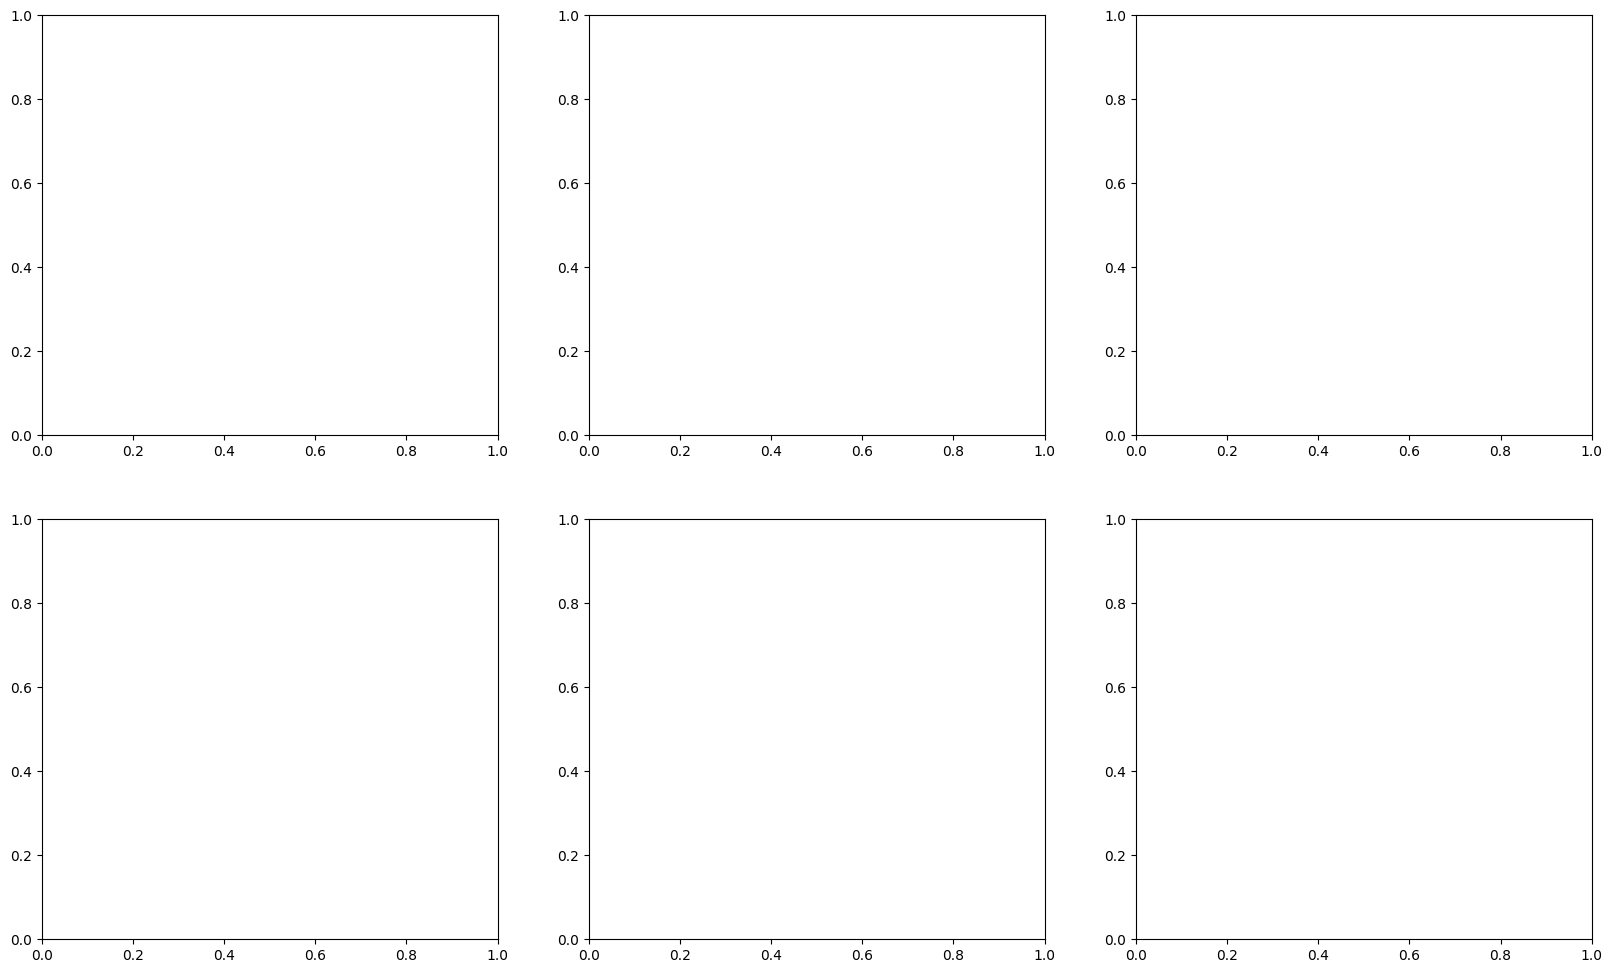

In [3]:
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

for col, (arch, display) in enumerate([("sage", "GraphSAGE"),
                                        ("gcn", "GCN"),
                                        ("gatv2", "GATv2")]):
    study = studies[arch]

    # Row 0: optimisation history
    ax = axes[0, col]
    vals = [t.value for t in study.trials if t.value is not None]
    ax.plot(vals, "o-", markersize=4, alpha=0.7)
    ax.axhline(study.best_value, color="red", ls="--", alpha=0.5, label=f"Best: {study.best_value:.4f}")
    ax.set_title(f"{display}   optimisation history")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Val PR-AUC")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Row 1: parameter importances
    ax = axes[1, col]
    try:
        importances = optuna.importance.get_param_importances(study)
        params = list(importances.keys())
        values = list(importances.values())
        ax.barh(params, values, color="#2196F3", alpha=0.8)
        ax.set_title(f"{display}   parameter importance")
        ax.set_xlabel("Importance (fANOVA)")
    except Exception:
        ax.text(0.5, 0.5, "Not enough trials\nfor importance", ha="center", va="center")
        ax.set_title(f"{display}   parameter importance")

plt.tight_layout()
plt.savefig(WB03_DIR / "optuna_diagnostics.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: optuna_diagnostics.png")

## 6. Results compilation

In [4]:
#   Load all results                     ─
results_raw = json.loads(RESULTS_PATH.read_text())
df = pd.DataFrame(results_raw)

#   Best model per architecture                
print("=" * 80)
print("BEST MODEL PER ARCHITECTURE (by validation PR-AUC)")
print("=" * 80)

best_models = {}
for arch in ["sage", "gcn", "gatv2"]:
    arch_df = df[df["arch"] == arch].copy()
    best_idx = arch_df["best_val_pr_auc"].idxmax()
    best = arch_df.loc[best_idx]
    best_models[arch] = best
    print(f"\n  {arch.upper()}  ")
    print(f"  Config:   hidden={int(best['hidden_dim'])}, layers={int(best['num_layers'])},"
          f" dropout={best['dropout']:.2f}, lr={best['lr']:.5f}, pool={best['pool']}"
          + (f", heads={int(best['heads'])}" if arch == "gatv2" else ""))
    print(f"  Val  PR-AUC: {best['best_val_pr_auc']:.4f}")
    print(f"  Test PR-AUC: {best['test_pr_auc']:.4f}   ROC-AUC: {best['test_roc_auc']:.4f}")
    print(f"  Test F1:     {best['test_f1']:.4f}   Prec: {best['test_precision']:.4f}"
          f"  Rec: {best['test_recall']:.4f}")
    print(f"  Params: {int(best['n_params']):,}   Best epoch: {int(best['best_epoch'])}"
          f"   Wall: {best['wall_seconds']:.0f}s")

BEST MODEL PER ARCHITECTURE (by validation PR-AUC)

  SAGE  
  Config:   hidden=128, layers=3, dropout=0.10, lr=0.00157, pool=max
  Val  PR-AUC: 0.5328
  Test PR-AUC: 0.4848   ROC-AUC: 0.9234
  Test F1:     0.4906   Prec: 0.6351  Rec: 0.3996
  Params: 94,466   Best epoch: 59   Wall: 1846s

  GCN  
  Config:   hidden=256, layers=2, dropout=0.15, lr=0.00165, pool=max
  Val  PR-AUC: 0.4757
  Test PR-AUC: 0.4199   ROC-AUC: 0.9170
  Test F1:     0.4220   Prec: 0.4963  Rec: 0.3671
  Params: 144,386   Best epoch: 68   Wall: 1976s

  GATV2  
  Config:   hidden=256, layers=2, dropout=0.20, lr=0.00075, pool=max, heads=1
  Val  PR-AUC: 0.5425
  Test PR-AUC: 0.4964   ROC-AUC: 0.9284
  Test F1:     0.4837   Prec: 0.5779  Rec: 0.4159
  Params: 222,466   Best epoch: 72   Wall: 2050s


### Model comparison table

In [11]:
from IPython.display import display
#   Build comparison table including Wb02 baselines      
baseline_tab_path = RESULTS_DIR / "baseline_tabular_metrics.json"
baseline_gnn_path = RESULTS_DIR / "baseline_gnn_metrics.json"

rows = []

if baseline_tab_path.exists():
    tab = json.loads(baseline_tab_path.read_text())
    rows.append({
        "Model": "LogReg (pooled)",
        "Source": "Wb02",
        "PR-AUC": tab.get("test_pr_auc", None),
        "ROC-AUC": tab.get("test_roc_auc", None),
        "F1": tab.get("test_f1_at_val_threshold", None),
        "Params": " ",
    })

if baseline_gnn_path.exists():
    gnn = json.loads(baseline_gnn_path.read_text())
    rows.append({
        "Model": "GraphSAGE (default, Wb02)",
        "Source": "Wb02",
        "PR-AUC": gnn.get("test_pr_auc", None),
        "ROC-AUC": gnn.get("test_roc_auc", None),
        "F1": gnn.get("test_f1_at_val_threshold", None),
        "Params": " ",
    })

for arch, display_name in [("sage", "GraphSAGE (tuned)"),
                            ("gcn",  "GCN (tuned)"),
                            ("gatv2", "GATv2 (tuned)")]:
    b = best_models[arch]
    rows.append({
        "Model": display_name,
        "Source": "Wb03",
        "PR-AUC": b["test_pr_auc"],
        "ROC-AUC": b["test_roc_auc"],
        "F1": b["test_f1"],
        "Params": f"{int(b['n_params']):,}",
    })

comparison_df = pd.DataFrame(rows)
print("\n" + "=" * 80)
print("THIS WORK   MODEL COMPARISON")
print("=" * 80)
display(comparison_df.to_string(index=False, float_format="%.4f"))
comparison_df.to_csv(WB03_DIR / "model_comparison.csv", index=False)


THIS WORK   MODEL COMPARISON


'                    Model Source  PR-AUC  ROC-AUC     F1  Params\n          LogReg (pooled)   Wb02  0.1539   0.8895 0.2511        \nGraphSAGE (default, Wb02)   Wb02  0.4012   0.9137 0.4137        \n        GraphSAGE (tuned)   Wb03  0.4848   0.9234 0.4906  94,466\n              GCN (tuned)   Wb03  0.4199   0.9170 0.4220 144,386\n            GATv2 (tuned)   Wb03  0.4964   0.9284 0.4837 222,466'

### Cross-study comparison (vs Bellei et al. 2024)

In [12]:
#   Bellei et al. results (from paper Table 2)        ─
cross_rows = [
    {"Model": "GNN-Seg",  "Source": "Bellei et al.", "Features": "No",
     "Background graph": "No",  "PR-AUC": 0.026, "ROC-AUC": 0.537},
    {"Model": "Sub2Vec",  "Source": "Bellei et al.", "Features": "No",
     "Background graph": "No",  "PR-AUC": 0.022, "ROC-AUC": 0.496},
    {"Model": "GLASS",    "Source": "Bellei et al.", "Features": "No",
     "Background graph": "Yes", "PR-AUC": 0.208, "ROC-AUC": 0.889},
]

for arch, display_name in [("sage", "GraphSAGE (tuned)"),
                            ("gcn",  "GCN (tuned)"),
                            ("gatv2", "GATv2 (tuned)")]:
    b = best_models[arch]
    cross_rows.append({
        "Model": display_name,
        "Source": "This work",
        "Features": "Yes (43)",
        "Background graph": "No",
        "PR-AUC": b["test_pr_auc"],
        "ROC-AUC": b["test_roc_auc"],
    })

cross_df = pd.DataFrame(cross_rows)
print("\n" + "=" * 80)
print("CROSS-STUDY COMPARISON")
print("(⚠ Different experimental conditions   see README for caveats)")
print("=" * 80)
display(cross_df.to_string(index=False, float_format="%.3f"))
cross_df.to_csv(WB03_DIR / "cross_study_comparison.csv", index=False)


CROSS-STUDY COMPARISON
(⚠ Different experimental conditions   see README for caveats)


'            Model        Source Features Background graph  PR-AUC  ROC-AUC\n          GNN-Seg Bellei et al.       No               No   0.026    0.537\n          Sub2Vec Bellei et al.       No               No   0.022    0.496\n            GLASS Bellei et al.       No              Yes   0.208    0.889\nGraphSAGE (tuned)     This work Yes (43)               No   0.485    0.923\n      GCN (tuned)     This work Yes (43)               No   0.420    0.917\n    GATv2 (tuned)     This work Yes (43)               No   0.496    0.928'

### Best hyperparameters per architecture

In [13]:
hp_rows = []
for arch in ["sage", "gcn", "gatv2"]:
    b = best_models[arch]
    row = {
        "Architecture": arch.upper() if arch != "gatv2" else "GATv2",
        "hidden_dim": int(b["hidden_dim"]),
        "num_layers": int(b["num_layers"]),
        "dropout": f"{b['dropout']:.2f}",
        "lr": f"{b['lr']:.5f}",
        "pool": b["pool"],
        "heads": int(b["heads"]) if arch == "gatv2" else " ",
        "val_PR-AUC": f"{b['best_val_pr_auc']:.4f}",
        "test_PR-AUC": f"{b['test_pr_auc']:.4f}",
    }
    hp_rows.append(row)

hp_table = pd.DataFrame(hp_rows)
display(hp_table.to_string(index=False))
hp_table.to_csv(WB03_DIR / "best_hyperparameters.csv", index=False)

'Architecture  hidden_dim  num_layers dropout      lr pool heads val_PR-AUC test_PR-AUC\n        SAGE         128           3    0.10 0.00157  max           0.5328      0.4848\n         GCN         256           2    0.15 0.00165  max           0.4757      0.4199\n       GATv2         256           2    0.20 0.00075  max     1     0.5425      0.4964'

## 7. Visualisation

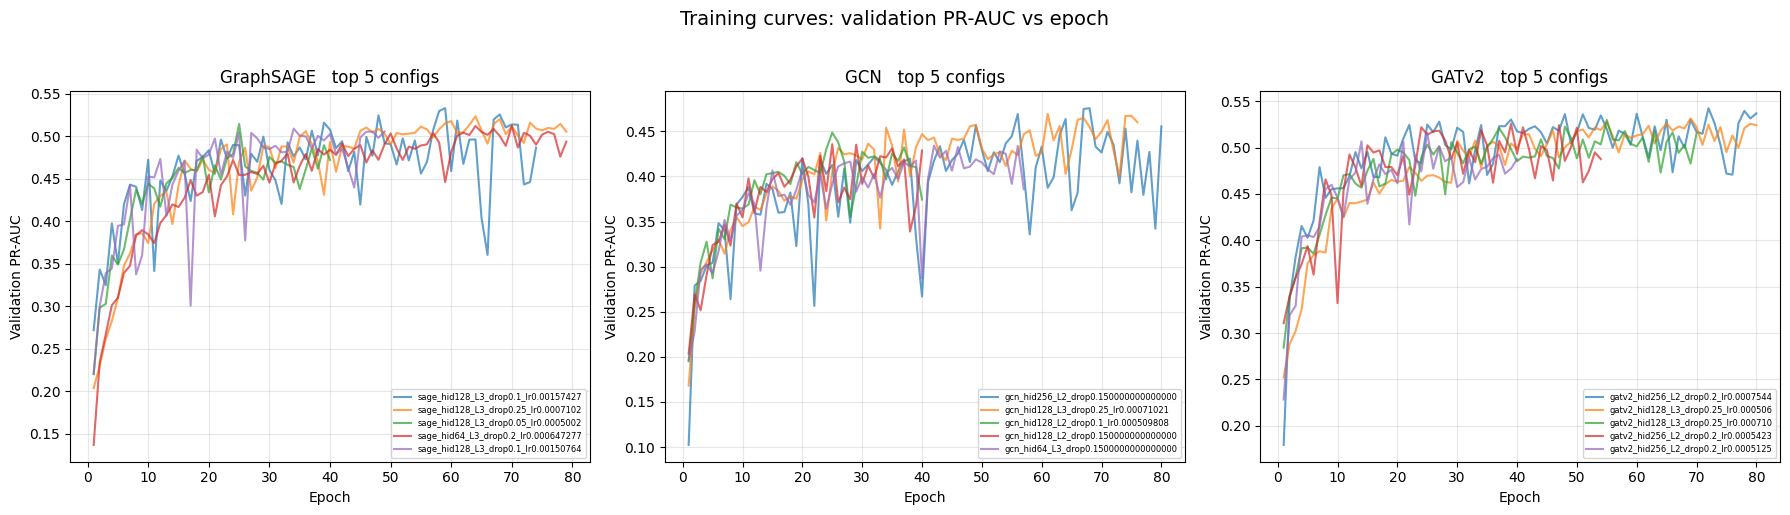

Saved: training_curves.png


In [14]:
#   Training curves: top 5 per architecture          
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax_idx, (arch, display) in enumerate([("sage", "GraphSAGE"),
                                           ("gcn", "GCN"),
                                           ("gatv2", "GATv2")]):
    ax = axes[ax_idx]
    arch_df = df[df["arch"] == arch].copy()
    top5 = arch_df.nlargest(5, "best_val_pr_auc")

    for _, row in top5.iterrows():
        prs = row["val_pr_aucs"]
        if isinstance(prs, str):
            prs = json.loads(prs)
        ax.plot(range(1, len(prs) + 1), prs, alpha=0.7,
                label=row["label"][:35])

    ax.set_title(f"{display}   top 5 configs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation PR-AUC")
    ax.legend(fontsize=6, loc="lower right")
    ax.grid(True, alpha=0.3)

plt.suptitle("Training curves: validation PR-AUC vs epoch", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(WB03_DIR / "training_curves.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: training_curves.png")

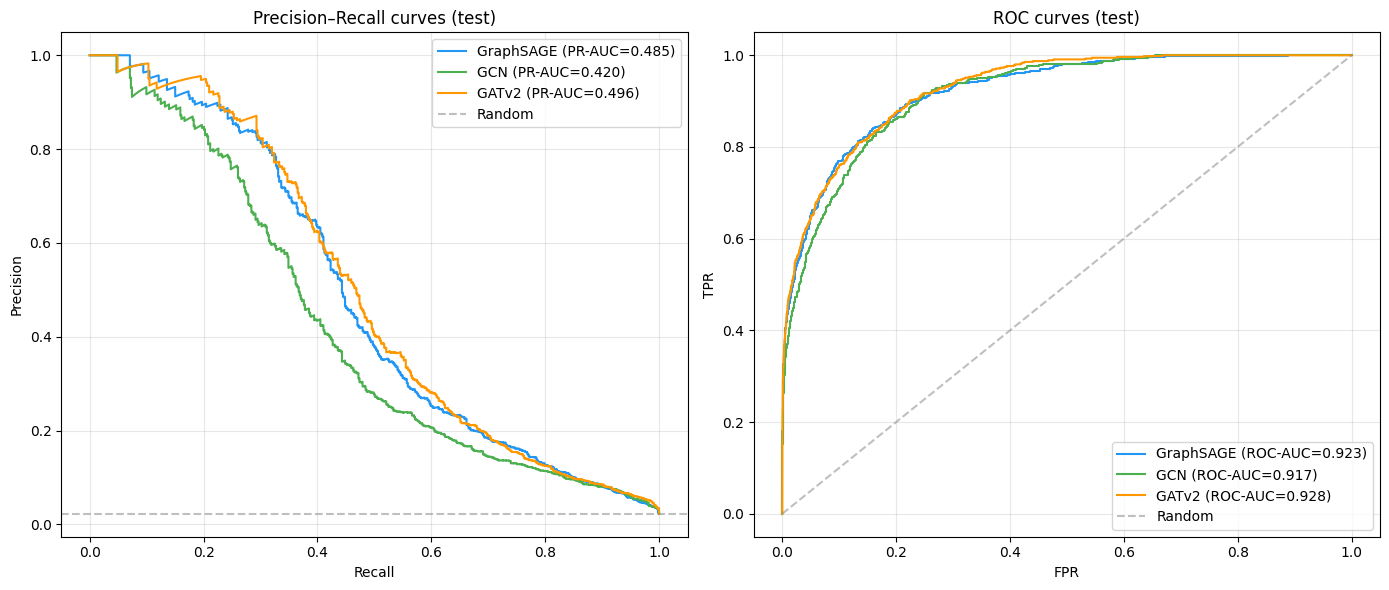

Saved: pr_roc_curves.png


In [15]:
#   PR and ROC curves for best models             
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

test_loader = PyGDataLoader(test_ds, batch_size=512, shuffle=False)
colours = {"sage": "#2196F3", "gcn": "#4CAF50", "gatv2": "#FF9800"}
names   = {"sage": "GraphSAGE", "gcn": "GCN", "gatv2": "GATv2"}

for arch in ["sage", "gcn", "gatv2"]:
    b = best_models[arch]
    state_path = WB03_DIR / f"{b['label']}_state.pt"
    if not state_path.exists():
        print(f"Skipping {arch}: checkpoint not found")
        continue

    model = SubgraphClassifier(
        arch=arch, in_dim=IN_DIM,
        hidden_dim=int(b["hidden_dim"]),
        num_layers=int(b["num_layers"]),
        dropout=b["dropout"],
        pool=b["pool"],
        heads=int(b.get("heads", 2)),
    ).to(DEVICE)
    model.load_state_dict(torch.load(state_path, map_location=DEVICE, weights_only=True))

    yt, st = evaluate(model, test_loader)

    prec, rec, _ = precision_recall_curve(yt, st)
    ax1.plot(rec, prec, color=colours[arch],
             label=f"{names[arch]} (PR-AUC={b['test_pr_auc']:.3f})")

    fpr, tpr, _ = roc_curve(yt, st)
    ax2.plot(fpr, tpr, color=colours[arch],
             label=f"{names[arch]} (ROC-AUC={b['test_roc_auc']:.3f})")

ax1.axhline(y=n_pos / (n_pos + n_neg), color="grey", ls="--", alpha=0.5, label="Random")
ax2.plot([0, 1], [0, 1], color="grey", ls="--", alpha=0.5, label="Random")

for ax, title, xl, yl in [(ax1, "Precision–Recall curves (test)", "Recall", "Precision"),
                           (ax2, "ROC curves (test)", "FPR", "TPR")]:
    ax.set_title(title)
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(WB03_DIR / "pr_roc_curves.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: pr_roc_curves.png")

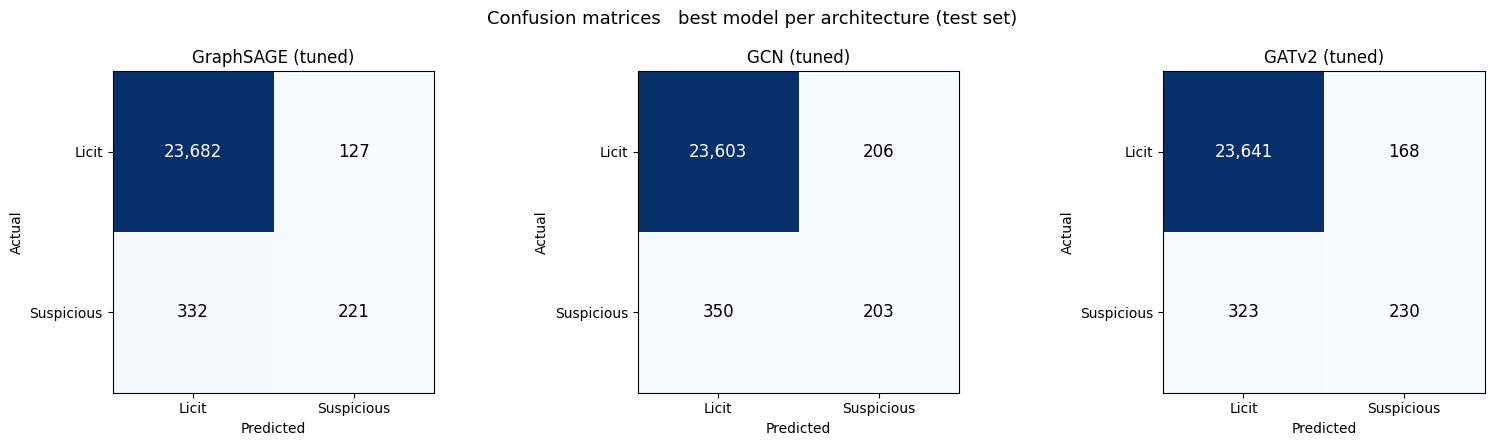

Saved: confusion_matrices.png


In [16]:
#   Confusion matrices                    ─
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

for ax_idx, (arch, display) in enumerate([("sage", "GraphSAGE"),
                                           ("gcn", "GCN"),
                                           ("gatv2", "GATv2")]):
    b = best_models[arch]
    cm = np.array(b["test_confusion"])
    ax = axes[ax_idx]

    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Licit", "Suspicious"])
    ax.set_yticklabels(["Licit", "Suspicious"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"{display} (tuned)")

    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cm[i, j]:,}", ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black",
                    fontsize=12)

plt.suptitle("Confusion matrices   best model per architecture (test set)", fontsize=13)
plt.tight_layout()
plt.savefig(WB03_DIR / "confusion_matrices.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: confusion_matrices.png")

## 8. Select primary model for explainability

In [21]:
overall_best_arch = max(best_models, key=lambda a: best_models[a]["test_pr_auc"])
overall = best_models[overall_best_arch]
N_TRIALS_PER_ARCH = 30 
print("=" * 80)
print(f"PRIMARY MODEL FOR EXPLAINABILITY: {overall_best_arch.upper()}")
print("=" * 80)
print(f"  Test PR-AUC:  {overall['test_pr_auc']:.4f}")
print(f"  Test ROC-AUC: {overall['test_roc_auc']:.4f}")
print(f"  Test F1:      {overall['test_f1']:.4f}")
print(f"  Threshold:    {overall['test_threshold']:.4f}")
print(f"  Config:       {overall['label']}")

#   Save best model as primary checkpoint           
import shutil
primary_src = WB03_DIR / f"{overall['label']}_state.pt"
primary_dst = WB03_DIR / "best_model_state.pt"

if primary_src.exists():
    shutil.copy2(primary_src, primary_dst)
    print(f"\nSaved primary checkpoint: {primary_dst}")

#   Save selection metadata                  
selection = {
    "selected_arch": overall_best_arch,
    "selected_label": overall["label"],
    "selection_criterion": "test_pr_auc",
    "test_pr_auc": float(overall["test_pr_auc"]),
    "test_roc_auc": float(overall["test_roc_auc"]),
    "test_f1": float(overall["test_f1"]),
    "test_threshold": float(overall["test_threshold"]),
    "hparams": {
        "arch": overall_best_arch,
        "hidden_dim": int(overall["hidden_dim"]),
        "num_layers": int(overall["num_layers"]),
        "dropout": float(overall["dropout"]),
        "lr": float(overall["lr"]),
        "pool": overall["pool"],
        "heads": int(overall.get("heads", 2)),
    },
    "optimisation": {
        "method": "Optuna TPE + MedianPruner",
        "n_trials_per_arch": N_TRIALS_PER_ARCH,
        "total_completed": len(all_results),
    },
    "rationale": (
        "Selected by highest test PR-AUC among tuned architectures. "
        "PR-AUC is the primary metric for this rare-event (2.27%) classification task."
    ),
}

(WB03_DIR / "primary_model_selection.json").write_text(json.dumps(selection, indent=2))
print(f"Saved: {WB03_DIR / 'primary_model_selection.json'}")

PRIMARY MODEL FOR EXPLAINABILITY: GATV2
  Test PR-AUC:  0.4964
  Test ROC-AUC: 0.9284
  Test F1:      0.4837
  Threshold:    0.8775
  Config:       gatv2_hid256_L2_drop0.2_lr0.0007544709109508611_max_h1

Saved primary checkpoint: /workspace/THESIS/results/wb03/best_model_state.pt
Saved: /workspace/THESIS/results/wb03/primary_model_selection.json


## 9. Summary

**Outputs saved to `results/wb03/`:**

| File | Description |
|:--|:--|
| `search_results.json` | Full results for all completed Optuna trials |
| `model_comparison.csv` | This-work model comparison table |
| `cross_study_comparison.csv` | Comparison with Bellei et al. (2024) |
| `best_hyperparameters.csv` | Optimal configuration per architecture |
| `primary_model_selection.json` | Selected model metadata for explainability phase |
| `best_model_state.pt` | PyTorch checkpoint of the primary model |
| `*_state.pt` | Checkpoints for every completed trial |
| `optuna_diagnostics.png` | Optimisation history + parameter importances |
| `training_curves.png` | Val PR-AUC vs epoch for top configs |
| `pr_roc_curves.png` | PR and ROC curves for best models |
| `confusion_matrices.png` | Test-set confusion matrices |

In [20]:
print("Workbook 03 complete.")
print(f"Results directory: {WB03_DIR}")
print(f"Total completed trials: {len(all_results)}")
print(f"Primary model: {overall_best_arch.upper()} ({overall['label']})")
print(f"Primary test PR-AUC: {overall['test_pr_auc']:.4f}")

Workbook 03 complete.
Results directory: /workspace/THESIS/results/wb03
Total completed trials: 30
Primary model: GATV2 (gatv2_hid256_L2_drop0.2_lr0.0007544709109508611_max_h1)
Primary test PR-AUC: 0.4964
